In [61]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.manifold import trustworthiness
from scipy.sparse.csgraph import dijkstra
from scipy.spatial import distance_matrix
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm.auto import tqdm
import tensorflow as tf
import numpy as np
import random
import queue
import json
		

# Antenna definitions
ASSIGNMENTS = [
	[0, 13, 31, 29, 3, 7, 1, 12 ],
	[30, 26, 21, 25, 24, 8, 22, 15],
	[28, 5, 10, 14, 6, 2, 16, 18],
	[19, 4, 23, 17, 20, 11, 9, 27]
]

ANTENNACOUNT = np.sum([len(antennaArray) for antennaArray in ASSIGNMENTS])

def load_calibrate_timedomain(path, offset_path):
	offsets = None
	with open(offset_path, "r") as offsetfile:
		offsets = json.load(offsetfile)
	
	def record_parse_function(proto):
		record = tf.io.parse_single_example(
			proto,
			{
				"csi": tf.io.FixedLenFeature([], tf.string, default_value=""),
				"pos-tachy": tf.io.FixedLenFeature([], tf.string, default_value=""),
				"time": tf.io.FixedLenFeature([], tf.float32, default_value=0),
			},
		)

		csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type=tf.float32), (ANTENNACOUNT, 1024, 2))
		csi = tf.complex(csi[:, :, 0], csi[:, :, 1])
		csi = tf.signal.fftshift(csi, axes=1)

		position = tf.ensure_shape(tf.io.parse_tensor(record["pos-tachy"], out_type=tf.float64), (3))
		time = tf.ensure_shape(record["time"], ())

		return csi, position[:2], time

	def apply_calibration(csi, pos, time):
		sto_offset = tf.tensordot(tf.constant(offsets["sto"]), 2 * np.pi * tf.range(tf.shape(csi)[1], dtype = np.float32) / tf.cast(tf.shape(csi)[1], np.float32), axes = 0)
		cpo_offset = tf.tensordot(tf.constant(offsets["cpo"]), tf.ones(tf.shape(csi)[1], dtype = np.float32), axes = 0)
		csi = tf.multiply(csi, tf.exp(tf.complex(0.0, sto_offset + cpo_offset)))

		return csi, pos, time

	def csi_time_domain(csi, pos, time):
		csi = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi, axes=1)),axes=1)

		return csi, pos, time

	def cut_out_taps(tap_start, tap_stop):
		def cut_out_taps_func(csi, pos, time):
			return csi[:,tap_start:tap_stop], pos, time

		return cut_out_taps_func

	def order_by_antenna_assignments(csi, pos, time):
		csi = tf.stack([tf.gather(csi, antenna_inidces) for antenna_inidces in ASSIGNMENTS])
		return csi, pos, time
	
	dataset = tf.data.TFRecordDataset(path)
	
	dataset = dataset.map(record_parse_function, num_parallel_calls = tf.data.AUTOTUNE)
	dataset = dataset.map(apply_calibration, num_parallel_calls = tf.data.AUTOTUNE)
	dataset = dataset.map(csi_time_domain, num_parallel_calls = tf.data.AUTOTUNE)
	dataset = dataset.map(cut_out_taps(507, 520), num_parallel_calls = tf.data.AUTOTUNE)
	dataset = dataset.map(order_by_antenna_assignments, num_parallel_calls = tf.data.AUTOTUNE)

	return dataset

inputpaths = [
	{
		"tfrecords" : "dichasus/dichasus-cf02.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf02.json"
	},
	{
		"tfrecords" : "dichasus/dichasus-cf03.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf03.json"
	},
	{
		"tfrecords" : "dichasus/dichasus-cf04.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf04.json"
	}
]

full_dataset = load_calibrate_timedomain(inputpaths[0]["tfrecords"], inputpaths[0]["offsets"])

for path in inputpaths[1:]:
	full_dataset = full_dataset.concatenate(load_calibrate_timedomain(path["tfrecords"], path["offsets"]))

In [62]:
# Decimate dataset: Use only every 4th datapoint (to reduce number of points)
training_set = full_dataset.enumerate().filter(lambda idx, value : (idx % 4 == 0))
training_set = training_set.map(lambda idx, value : value)

2025-02-26 12:27:35.326652: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [63]:
groundtruth_positions = []
csi_time_domain = []
timestamps = []

for csi, pos, time in training_set.batch(1000):
	csi_time_domain.append(csi.numpy())
	groundtruth_positions.append(pos.numpy())
	timestamps.append(time.numpy())

csi_time_domain = np.concatenate(csi_time_domain)
groundtruth_positions = np.concatenate(groundtruth_positions)
timestamps = np.concatenate(timestamps)

In [67]:
groundtruth_positions.shape

(20997, 2)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Parameters
W = 1024  # Number of OFDM subcarriers
modulation_order = 16  # 16-QAM modulation
C = W // 8  # Cyclic Prefix Length
L = 13  # Channel length
Lp = 5  # Perturbation length
noise_power = 0.1  # Noise power
B = 32  # Number of antennas

# Generate frequency-domain symbols (16-QAM)
data = np.random.randint(0, modulation_order, W)
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)
qam_symbols /= np.sqrt(10)  # Normalize for unit average power

# Convert to time domain using IFFT
time_domain_signal = np.fft.ifft(qam_symbols)

# Generate perturbation sequence
A_k = np.random.uniform(0, 1, Lp)  # Amplitude
phi_k = np.random.uniform(0, 2 * np.pi, Lp)  # Phase
p_bar = A_k * np.exp(1j * phi_k)  # Construct perturbation sequence
p_bar /= np.linalg.norm(p_bar)  # Normalize perturbation ||p_bar|| = 1

# Apply perturbation in the time domain
perturbed_signal = np.convolve(p_bar, time_domain_signal, mode="full")[:W]

# Add Cyclic Prefix (CP)
cyclic_prefix = perturbed_signal[-C:]
transmit_signal = np.concatenate([cyclic_prefix, perturbed_signal])

# Load real CSI matrix
csi_time_domain = csi_time_domain.reshape(20997, 32, 13)  # Reshape to expected dimensions
num_csi_instances = csi_time_domain.shape[0]

y_real_all = np.zeros((num_csi_instances, B, W + C), dtype=complex)
H_pert_all = np.zeros((num_csi_instances, B, W), dtype=complex)  # Store estimated perturbed H in frequency domain

for i in range(num_csi_instances):
    H_real = csi_time_domain[i]  # Extract real CSI matrix (32x13) for instance i
    for b in range(B):
        # Compute y_real
        y_real = convolve(H_real[b], transmit_signal, mode='full')[:W + C]
        
        # Add noise
        noise = np.sqrt(noise_power / 2) * (np.random.randn(W + C) + 1j * np.random.randn(W + C))
        y_real_noisy = y_real + noise
        
        # Remove CP
        y_real_no_cp = y_real_noisy[C:]
        
        # Convert to frequency domain
        y_freq = np.fft.fft(y_real_no_cp)  # FFT of received signal
        s_freq = np.fft.fft(time_domain_signal)  # FFT of transmitted signal
        
        # Compute H_pert in frequency domain
        H_pert_all[i, b, :] = y_freq / s_freq  # Element-wise division
        
        # Convert H_pert back to time domain and truncate to 32x13
        H_pert_time = np.fft.ifft(H_pert_all[i, b, :])[:L]  # Convert and truncate
        csi_time_domain[i, b, :] = H_pert_time  # Replace real CSI with estimated perturbed CSI

# Reshape back to original (20997, 4, 8, 13)
csi_time_domain = csi_time_domain.reshape(20997, 4, 8, 13)

print("Updated CSI Shape:", csi_time_domain.shape)

Updated CSI Shape: (20997, 4, 8, 13)


657/657 [==============================] - 24s 36ms/step
Fixed Ground Truth Shape: (20997, 2)
Fixed Predicted Positions Shape: (20997, 2)


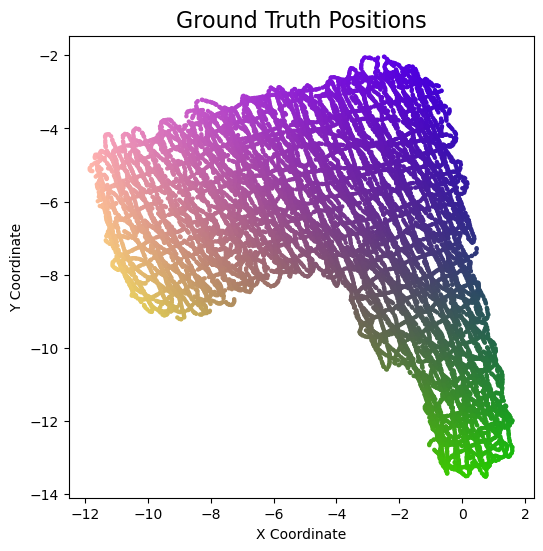

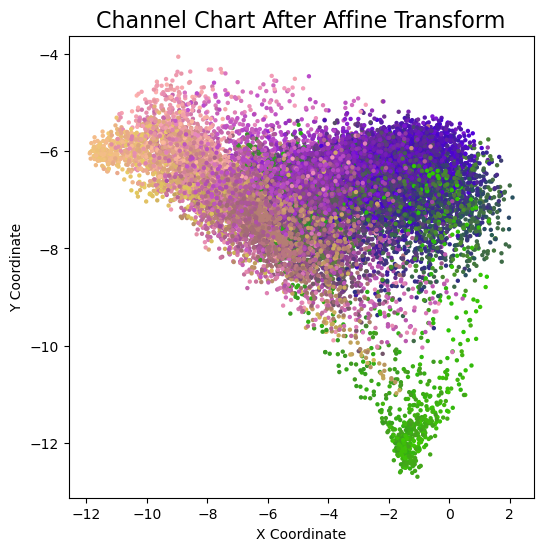

In [56]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure CSI data has the correct shape for prediction
if 'csi_time_domain' not in globals():
    raise ValueError("CSI data is not defined.")

if csi_time_domain.ndim != 4:
    print("Reshaping csi_time_domain...")
    csi_time_domain = csi_time_domain.reshape(-1, 4, 8, 13)

# Ensure model is defined
if 'model' not in globals():
    raise ValueError("Model is not defined. Load or train the model before making predictions.")

# Predict using both inputs (for Siamese Model)
predicted_positions = model.predict([csi_time_domain, csi_time_domain])

# Ensure groundtruth_positions and predicted_positions are valid
if 'groundtruth_positions' not in globals() or groundtruth_positions is None:
    raise ValueError("Ground truth positions are missing.")

if predicted_positions is None:
    raise ValueError("Predicted positions are missing.")

# Ensure groundtruth_positions is (N,2)
if groundtruth_positions.ndim == 1:
    print("Warning: Ground truth positions are 1D. Converting to (N,2)...")
    groundtruth_positions = np.column_stack((groundtruth_positions, np.zeros(groundtruth_positions.shape[0])))

# Ensure predicted_positions is (N,2)
predicted_positions = predicted_positions[:, :2]  # Keep only first two columns

# Verify shapes before transformation
print("Fixed Ground Truth Shape:", groundtruth_positions.shape)  # Should be (20997,2)
print("Fixed Predicted Positions Shape:", predicted_positions.shape)  # Should be (20997,2)

# Define the affine transformation function
def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    groundtruth_pos = np.array(groundtruth_pos)
    channel_chart_pos = np.array(channel_chart_pos)

    if groundtruth_pos.shape[1] != 2 or channel_chart_pos.shape[1] != 2:
        raise ValueError("Both groundtruth_pos and channel_chart_pos must have shape (N, 2)")

    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:, :-1]  

    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond=None)

    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

# Apply affine transformation
predicted_positions_transformed = affine_transform_channel_chart(groundtruth_positions, predicted_positions)

# Safe normalize function to avoid division by zero
def safe_normalize(in_data):
    min_val, max_val = np.min(in_data), np.max(in_data)
    if min_val == max_val:
        return np.zeros_like(in_data)  # Avoid division by zero
    return (in_data - min_val) / (max_val - min_val)

# Function to plot colorized data points
def plot_colorized(positions, groundtruth_positions, title=None, show=True, alpha=1.0):
    rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * safe_normalize(groundtruth_positions[:, 0])
    rgb_values[:, 1] = 0.8 * safe_normalize(np.square(np.linalg.norm(groundtruth_positions, axis=1)))
    rgb_values[:, 2] = 0.9 * safe_normalize(groundtruth_positions[:, 1])

    plt.figure(figsize=(6, 6))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c=rgb_values, alpha=alpha, s=10, linewidths=0)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    if show:
        plt.show()

# Plot results
plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")
plot_colorized(predicted_positions_transformed, groundtruth_positions, title="Channel Chart After Affine Transform")


657/657 [==============================] - 39s 59ms/step


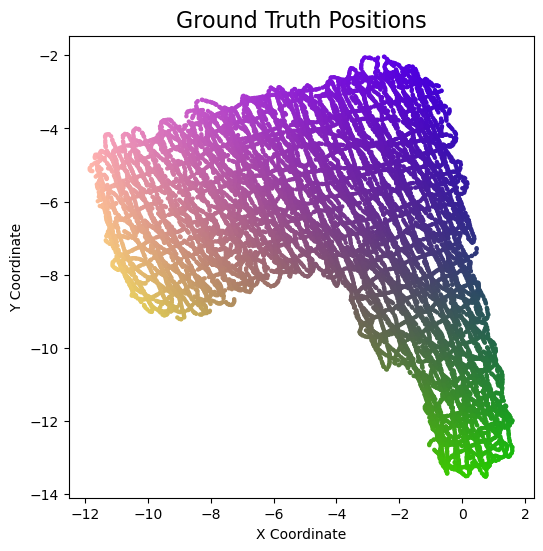

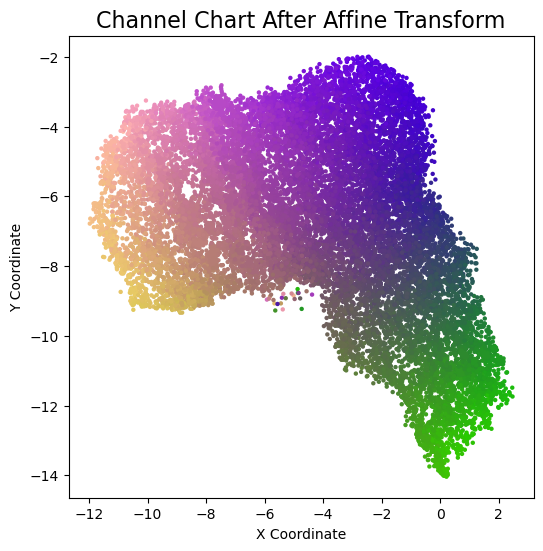

657/657 [==============================] - 31s 46ms/step


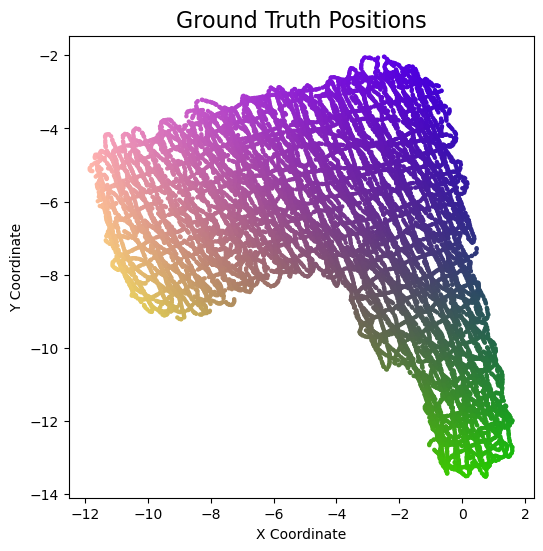

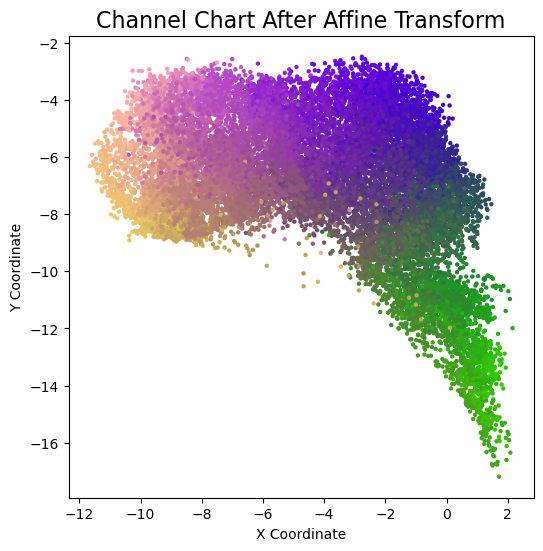

657/657 [==============================] - 30s 46ms/step


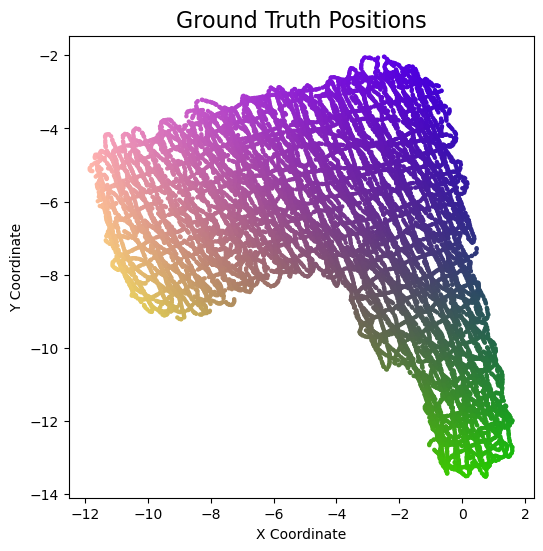

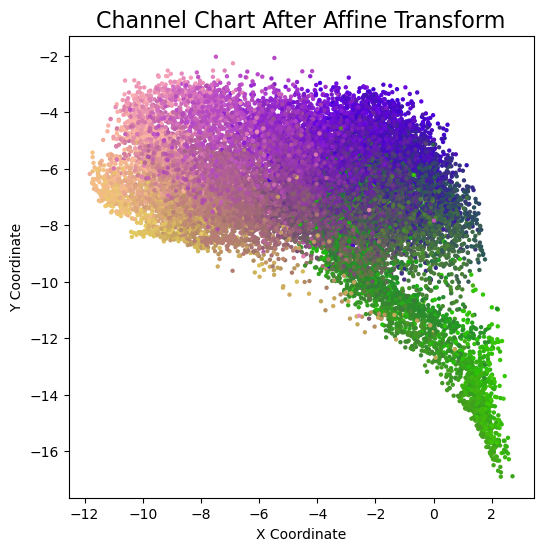

657/657 [==============================] - 32s 47ms/step


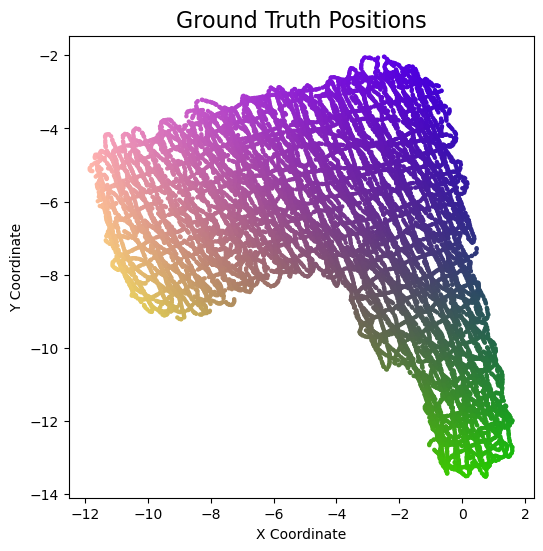

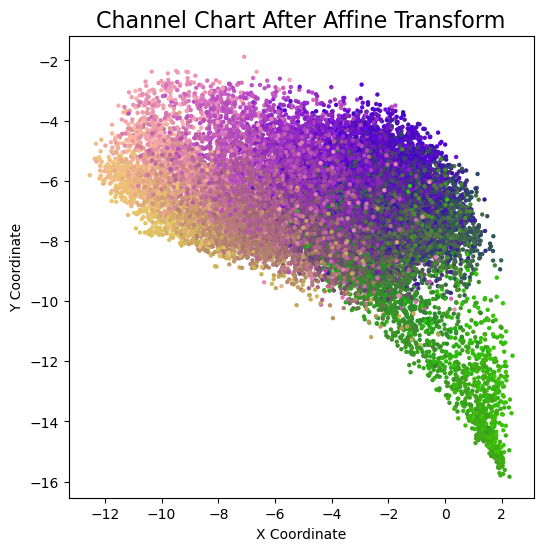

657/657 [==============================] - 28s 42ms/step


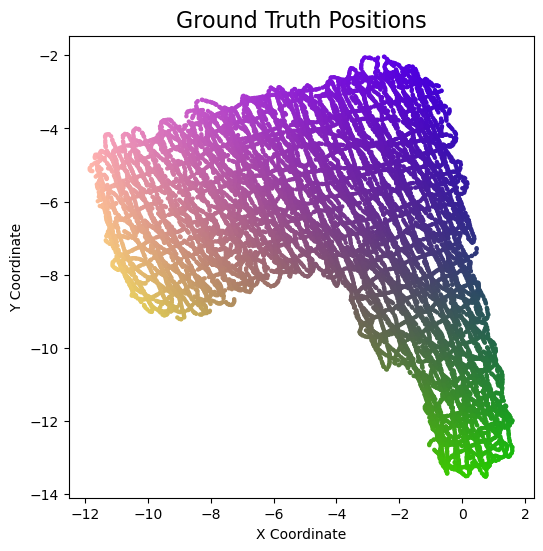

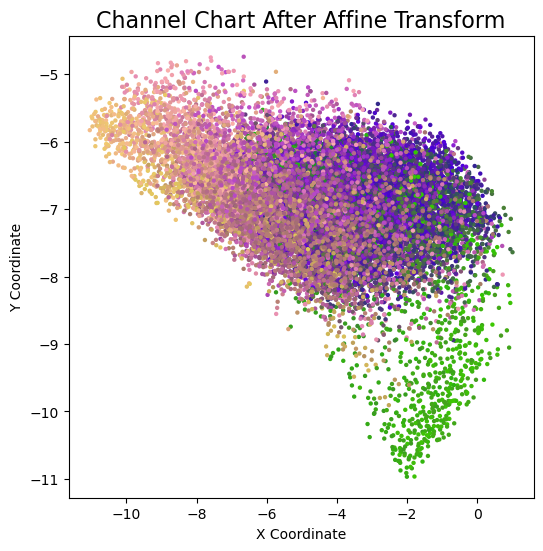

657/657 [==============================] - 36s 54ms/step


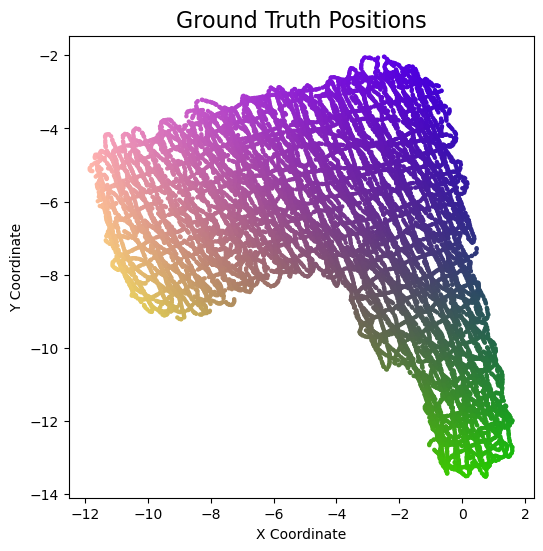

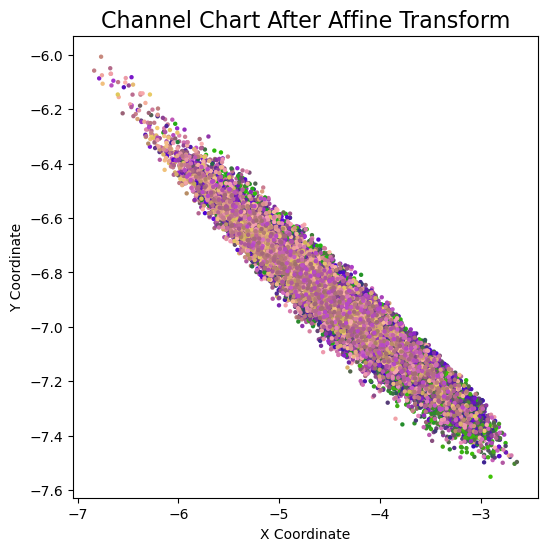

657/657 [==============================] - 28s 42ms/step


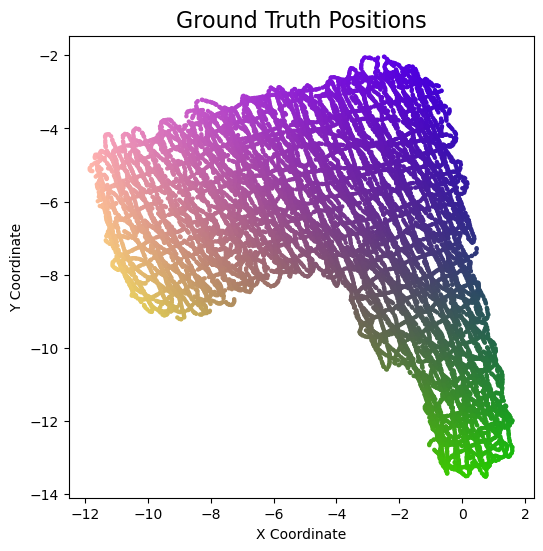

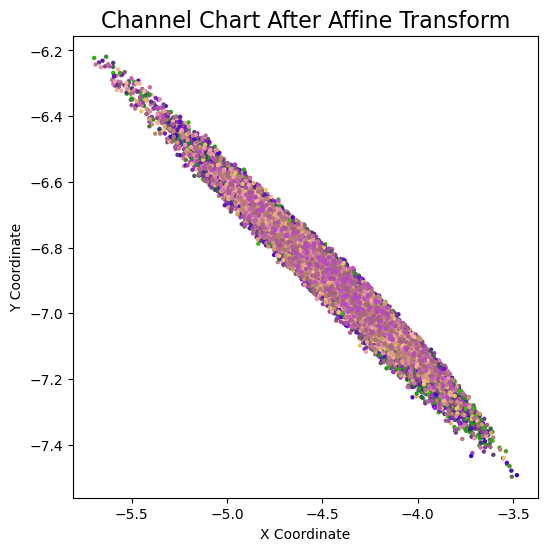

657/657 [==============================] - 27s 41ms/step


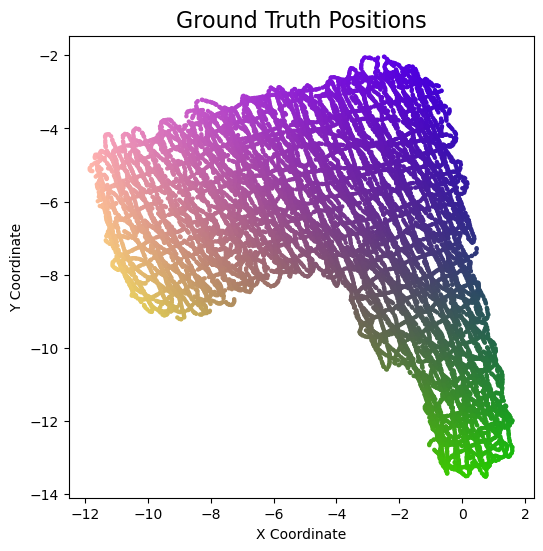

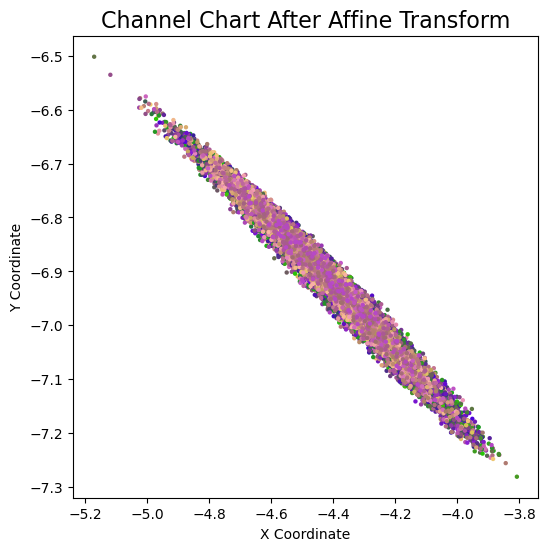

657/657 [==============================] - 26s 39ms/step


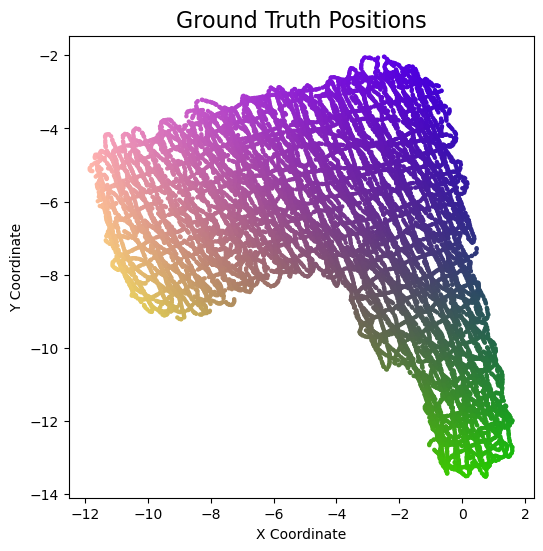

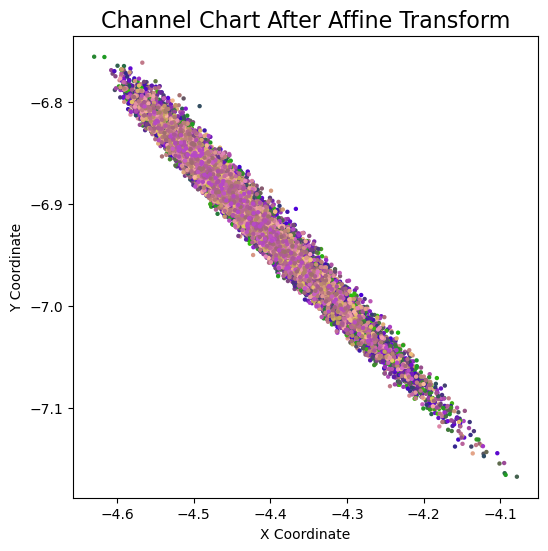

657/657 [==============================] - 30s 45ms/step


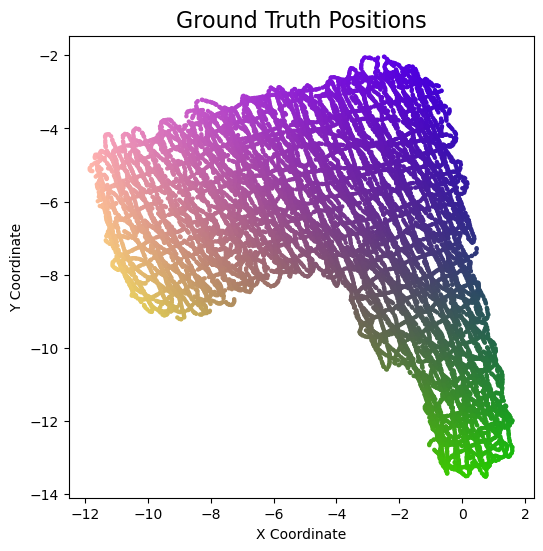

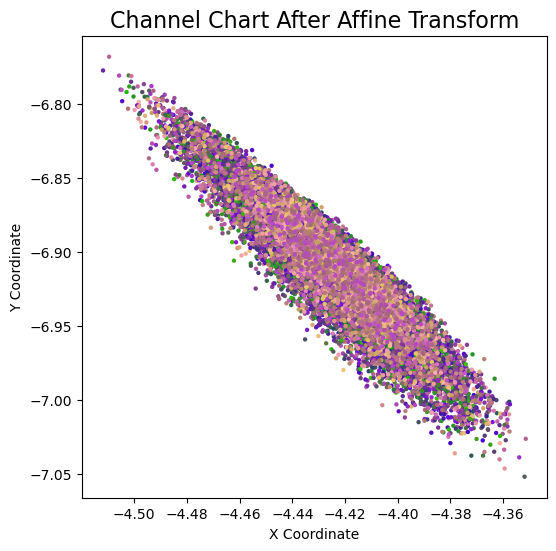

657/657 [==============================] - 36s 53ms/step


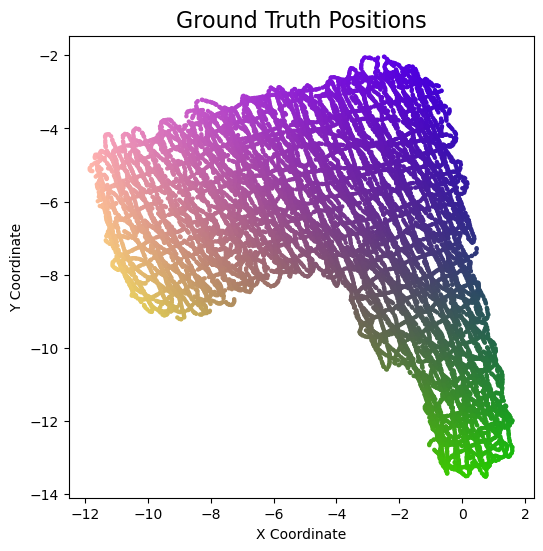

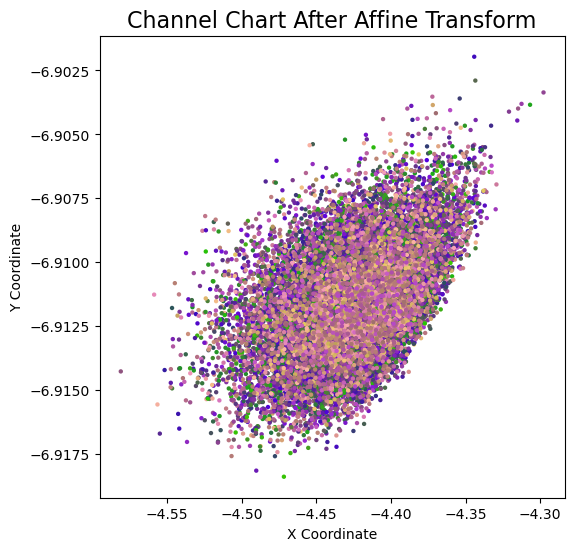

124/657 [====>.........................] - ETA: 13s

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Parameters
W = 1024  # Number of OFDM subcarriers
modulation_order = 16  # 16-QAM modulation
C = W // 8  # Cyclic Prefix Length
L = 13  # Channel length
noise_power = 0.1  # Noise power
B = 32  # Number of antennas

# Generate frequency-domain symbols (16-QAM)
data = np.random.randint(0, modulation_order, W)
qam_symbols = (2 * (data % 4) - 3) + 1j * (2 * (data // 4) - 3)
qam_symbols /= np.sqrt(10)  # Normalize for unit average power

# Convert to time domain using IFFT
time_domain_signal = np.fft.ifft(qam_symbols)
Lp_values = np.arange(1, 17)
mae_values = []
# Generate perturbation sequence
for Lp in Lp_values:
    A_k = np.random.uniform(0, 1, Lp)  # Amplitude
    phi_k = np.random.uniform(0, 2 * np.pi, Lp)  # Phase
    p_bar = A_k * np.exp(1j * phi_k)  # Construct perturbation sequence
    p_bar /= np.linalg.norm(p_bar)  # Normalize perturbation ||p_bar|| = 1

    # Apply perturbation in the time domain
    perturbed_signal = np.convolve(p_bar, time_domain_signal, mode="full")[:W]

    # Add Cyclic Prefix (CP)
    cyclic_prefix = perturbed_signal[-C:]
    transmit_signal = np.concatenate([cyclic_prefix, perturbed_signal])

    # Load real CSI matrix
    csi_time_domain = csi_time_domain.reshape(20997, 32, 13)  # Reshape to expected dimensions
    num_csi_instances = csi_time_domain.shape[0]

    y_real_all = np.zeros((num_csi_instances, B, W + C), dtype=complex)
    H_pert_all = np.zeros((num_csi_instances, B, W), dtype=complex)  # Store estimated perturbed H in frequency domain

    for i in range(num_csi_instances):
        H_real = csi_time_domain[i]  # Extract real CSI matrix (32x13) for instance i
        for b in range(B):
            # Compute y_real
            y_real = convolve(H_real[b], transmit_signal, mode='full')[:W + C]

            # Add noise
            noise = np.sqrt(noise_power / 2) * (np.random.randn(W + C) + 1j * np.random.randn(W + C))
            y_real_noisy = y_real + noise

            # Remove CP
            y_real_no_cp = y_real_noisy[C:]

            # Convert to frequency domain
            y_freq = np.fft.fft(y_real_no_cp)  # FFT of received signal
            s_freq = np.fft.fft(time_domain_signal)  # FFT of transmitted signal

            # Compute H_pert in frequency domain
            H_pert_all[i, b, :] = y_freq / s_freq  # Element-wise division

            # Convert H_pert back to time domain and truncate to 32x13
            H_pert_time = np.fft.ifft(H_pert_all[i, b, :])[:L]  # Convert and truncate
            csi_time_domain[i, b, :] = H_pert_time  # Replace real CSI with estimated perturbed CSI

    # Reshape back to original (20997, 4, 8, 13)
    csi_time_domain = csi_time_domain.reshape(20997, 4, 8, 13)
    predicted_positions = model.predict([csi_time_domain, csi_time_domain])
    # Ensure groundtruth_positions and predicted_positions are valid
    if 'groundtruth_positions' not in globals() or groundtruth_positions is None:
        raise ValueError("Ground truth positions are missing.")

    if predicted_positions is None:
        raise ValueError("Predicted positions are missing.")

    # Ensure groundtruth_positions is (N,2)
    if groundtruth_positions.ndim == 1:
        print("Warning: Ground truth positions are 1D. Converting to (N,2)...")
        groundtruth_positions = np.column_stack((groundtruth_positions, np.zeros(groundtruth_positions.shape[0])))

    # Ensure predicted_positions is (N,2)
    predicted_positions = predicted_positions[:, :2]  # Keep only first two columns
    def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
        groundtruth_pos = np.array(groundtruth_pos)
        channel_chart_pos = np.array(channel_chart_pos)

        if groundtruth_pos.shape[1] != 2 or channel_chart_pos.shape[1] != 2:
            raise ValueError("Both groundtruth_pos and channel_chart_pos must have shape (N, 2)")

        pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
        unpad = lambda x: x[:, :-1]  

        A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond=None)

        transform = lambda x: unpad(np.dot(pad(x), A))
        return transform(channel_chart_pos)

    # Apply affine transformation
    predicted_positions_transformed = affine_transform_channel_chart(groundtruth_positions, predicted_positions)

    # Safe normalize function to avoid division by zero
    def safe_normalize(in_data):
        min_val, max_val = np.min(in_data), np.max(in_data)
        if min_val == max_val:
            return np.zeros_like(in_data)  # Avoid division by zero
        return (in_data - min_val) / (max_val - min_val)

    # Function to plot colorized data points
    def plot_colorized(positions, groundtruth_positions, title=None, show=True, alpha=1.0):
        rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
        rgb_values[:, 0] = 1 - 0.9 * safe_normalize(groundtruth_positions[:, 0])
        rgb_values[:, 1] = 0.8 * safe_normalize(np.square(np.linalg.norm(groundtruth_positions, axis=1)))
        rgb_values[:, 2] = 0.9 * safe_normalize(groundtruth_positions[:, 1])

        plt.figure(figsize=(6, 6))
        if title is not None:
            plt.title(title, fontsize=16)
        plt.scatter(positions[:, 0], positions[:, 1], c=rgb_values, alpha=alpha, s=10, linewidths=0)
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        if show:
            plt.show()

    # Plot results
    plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")
    plot_colorized(predicted_positions_transformed, groundtruth_positions, title="Channel Chart After Affine Transform")


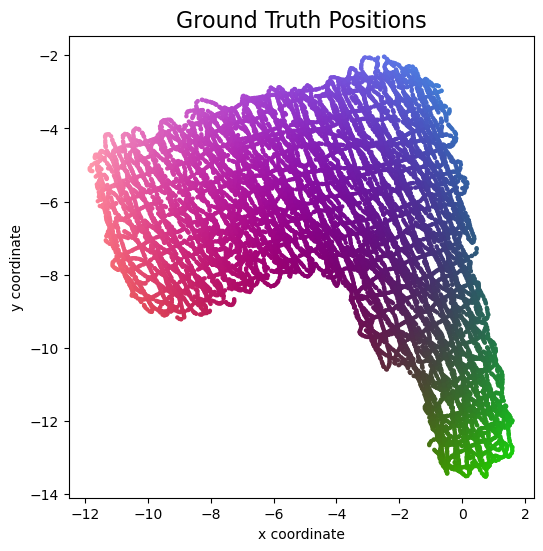

In [15]:
def plot_colorized(positions, groundtruth_positions, title = None, show = True, alpha = 1.0):
	# Generate RGB colors for datapoints
	center_point = np.zeros(2, dtype = np.float32)
	center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
	center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
	NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
	rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
	rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
	rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions - center_point, axis=1)))
	rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

	# Plot datapoints
	plt.figure(figsize=(6, 6))
	if title is not None:
		plt.title(title, fontsize=16)
	plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
	plt.xlabel("x coordinate")
	plt.ylabel("y coordinate")
	if show: plt.savefig('plt1.png')

plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")


In [16]:
@tf.function
def compute_adp_dissimilarity_matrix(csi_array):
	output = tf.TensorArray(tf.float32, size = csi_array.shape[0])

	powers = tf.einsum("lbmt,lbmt->lbt", csi_array, tf.math.conj(csi_array))
	for i in tf.range(csi_array.shape[0]):
		w = csi_array[i:,:,:,:]
		h = csi_array[i,:,:,:]

		dotproducts = tf.abs(tf.square(tf.einsum("bmt,lbmt->lbt", tf.math.conj(h), w)))
		d_new = tf.math.reduce_sum(1 - dotproducts / tf.math.real(powers[i] * powers[i:]), axis = (1, 2))
		d = tf.concat([tf.zeros(i), tf.maximum(d_new, 0)], 0)

		output = output.write(i, d)

	dissim_upper_tri = output.stack()
	return dissim_upper_tri + tf.transpose(dissim_upper_tri)

adp_dissimilarity_matrix = compute_adp_dissimilarity_matrix(csi_time_domain).numpy()

In [17]:
# Compute timestamp-based dissimilarity matrix
timestamp_dissimilarity_matrix = np.abs(np.subtract.outer(timestamps, timestamps))

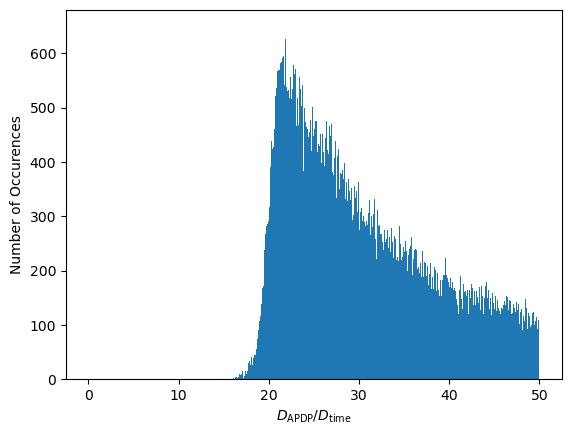

In [18]:
TIME_THRESHOLD = 2
small_time_dissimilarity_indices = np.logical_and(timestamp_dissimilarity_matrix < TIME_THRESHOLD, timestamp_dissimilarity_matrix > 0)
small_time_dissimilarities = timestamp_dissimilarity_matrix[small_time_dissimilarity_indices]
small_adp_dissimilarities = adp_dissimilarity_matrix[small_time_dissimilarity_indices]

n_bins = 1500

fig, ax1 = plt.subplots()
occurences, edges, patches = ax1.hist(small_adp_dissimilarities / small_time_dissimilarities, range = (0, 50), bins = n_bins)
ax1.set_xlabel("$D_\mathrm{APDP} / D_\mathrm{time}$")
ax1.set_ylabel("Number of Occurences")
plt.savefig('plt2.png')

gamma = 0.01666666753590107


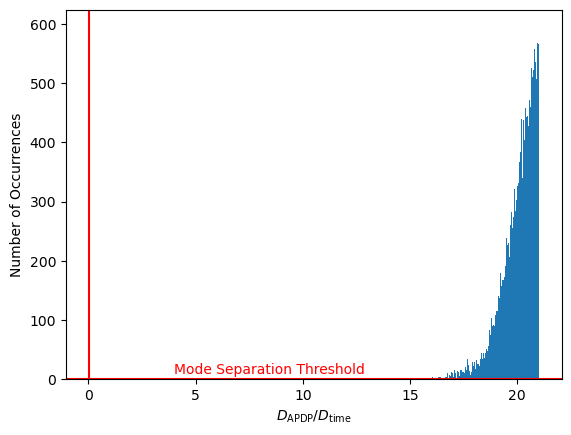

In [19]:
bin_centers = edges[:-1] + np.diff(edges) / 2.
max_bin = np.argmax(occurences)

if max_bin > 0:
    min_threshold = np.quantile(occurences[:max_bin], 0.5)

    for threshold_bin in range(max_bin - 1, -1, -1):
        if occurences[threshold_bin] < min_threshold:
            break

    scaling_factor = bin_centers[threshold_bin]

    plt.bar(bin_centers[:max_bin], occurences[:max_bin], width=edges[1] - edges[0])
    plt.axhline(y=min_threshold, color='r', linestyle='-')
    plt.text(4, min_threshold + 10, "Mode Separation Threshold", color='r',)
    plt.axvline(x=scaling_factor, color='r', linestyle='-')
    plt.xlabel("$D_\mathrm{APDP} / D_\mathrm{time}$")
    plt.ylabel("Number of Occurrences")
    plt.savefig('plt3.png')

    print("gamma =", scaling_factor)
else:
    print("No occurrences to plot.")


In [20]:
# Fuse ADP-based and time-based dissimilarity matrices
dissimilarity_matrix_fused = np.minimum(adp_dissimilarity_matrix, timestamp_dissimilarity_matrix * scaling_factor)

In [21]:
n_neighbors = 20

nbrs_alg = NearestNeighbors(n_neighbors = n_neighbors, metric="precomputed", n_jobs = -1)
nbrs = nbrs_alg.fit(dissimilarity_matrix_fused)
nbg = kneighbors_graph(nbrs, n_neighbors, metric = "precomputed", mode="distance")

In [14]:
import multiprocess as mpp 

def shortest_path_worker(todo_queue, output_queue):
	while True:
		index = todo_queue.get()

		if index == -1:
			output_queue.put((-1, None))
			break

		d = dijkstra(nbg, directed=False, indices=index)
		output_queue.put((index, d))


dissimilarity_matrix_geodesic = np.zeros((nbg.shape[0], nbg.shape[1]), dtype = np.float32)

with tqdm(total = nbg.shape[0]**2) as pbar:
	todo_queue = mpp.Queue()
	output_queue = mpp.Queue()

	for i in range(nbg.shape[0]):
		todo_queue.put(i)
	
	for i in range(mp.cpu_count()):
		todo_queue.put(-1)
		p = mpp.Process(target = shortest_path_worker, args = (todo_queue, output_queue))
		p.start()

	finished_processes = 0
	while finished_processes != mpp.cpu_count():
		i, d = output_queue.get()

		if i == -1:
			finished_processes = finished_processes + 1
		else:
			dissimilarity_matrix_geodesic[i,:] = d
			pbar.update(len(d))

100%|████████████████████████| 440874009/440874009 [02:20<00:00, 3128838.47it/s]


In [15]:
# Compute distances between groundtruth positions
groundtruth_distance_matrix = distance_matrix(groundtruth_positions, groundtruth_positions)

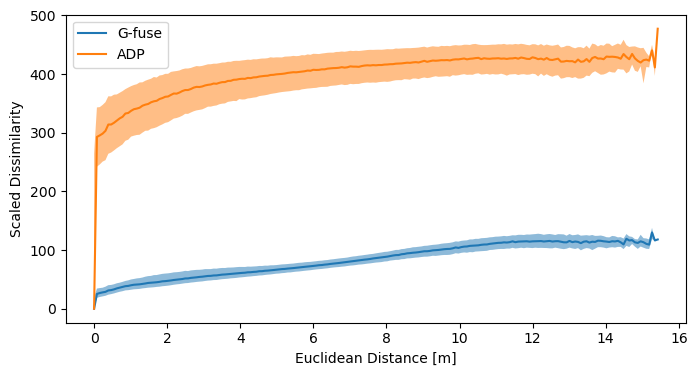

In [16]:
def plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix, distance_matrix, label = None):
	nth_reduction = 10
	dissimilarities_flat = dissimilarity_matrix[::nth_reduction, ::nth_reduction].flatten()
	distances_flat = distance_matrix[::nth_reduction, ::nth_reduction].flatten()
	
	max_distance = np.max(distances_flat)
	bins = np.linspace(0, max_distance, 200)
	bin_indices = np.digitize(distances_flat, bins)
	
	bin_medians = np.zeros(len(bins) - 1)
	bin_25_perc = np.zeros(len(bins) - 1)
	bin_75_perc = np.zeros(len(bins) - 1)
	for i in range(1, len(bins)):
		bin_values = dissimilarities_flat[bin_indices == i]
		bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
	
	plt.plot(bins[:-1], bin_medians, label = label)
	plt.fill_between(bins[:-1], bin_25_perc, bin_75_perc, alpha=0.5)
		
plt.figure(figsize=(8,4))

plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix_geodesic, groundtruth_distance_matrix, "G-fuse")
plot_dissimilarity_over_euclidean_distance(scaling_factor * adp_dissimilarity_matrix, groundtruth_distance_matrix, "ADP")

plt.legend()
plt.xlabel("Euclidean Distance [m]")
plt.ylabel("Scaled Dissimilarity")
plt.savefig('plt3.png')

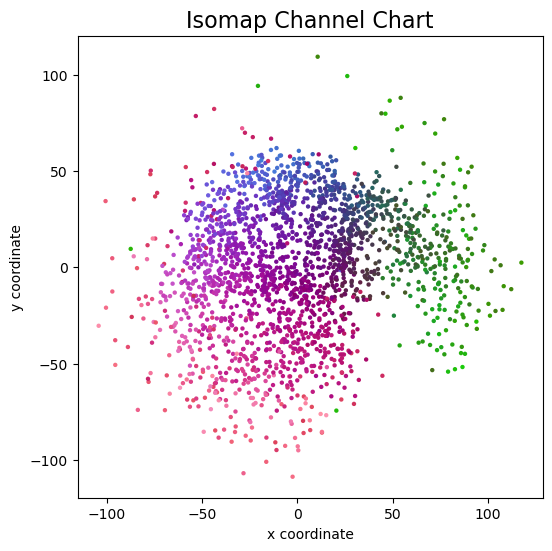

In [17]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

nth_reduction = 10

# Assuming dissimilarity_matrix_geodesic is defined
reduced_dissimilarity_matrix_geodesic = dissimilarity_matrix_geodesic[::nth_reduction, ::nth_reduction]

# Check for infinity or large values
if np.any(np.isinf(reduced_dissimilarity_matrix_geodesic)) or np.max(reduced_dissimilarity_matrix_geodesic) > 1e6:
    # Handle infinity or large values
    reduced_dissimilarity_matrix_geodesic[np.isinf(reduced_dissimilarity_matrix_geodesic)] = 0  # Replace infinity with 0
    reduced_dissimilarity_matrix_geodesic[reduced_dissimilarity_matrix_geodesic > 1e6] = 1e6  # Clip large values to 1e6

embedding_isomap = MDS(metric=True, dissimilarity='precomputed', max_iter=80, normalized_stress=False)
proj_isomap = embedding_isomap.fit_transform(reduced_dissimilarity_matrix_geodesic)

# Assuming groundtruth_positions is defined
plot_colorized(proj_isomap, groundtruth_positions[::nth_reduction], title="Isomap Channel Chart")
plt.savefig('plt4.png')

In [18]:
class FeatureEngineeringLayer(tf.keras.layers.Layer):
	def __init__(self):
		super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

	def call(self, csi):
		# Compute sample correlations for any combination of two antennas in the whole system
		# for the same datapoint and time tap.
		sample_autocorrelations = tf.einsum("damt,dbnt->dtabmn", csi, tf.math.conj(csi))
		return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

In [19]:
array_count = np.shape(csi_time_domain)[1]
antenna_per_array_count = np.shape(csi_time_domain)[2]
tap_count = np.shape(csi_time_domain)[3]

cc_embmodel_input = tf.keras.Input(shape=(array_count, antenna_per_array_count, tap_count), name="input", dtype = tf.complex64)
cc_embmodel_output = FeatureEngineeringLayer()(cc_embmodel_input)
cc_embmodel_output = tf.keras.layers.Flatten()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(1024, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(512, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(256, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(128, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(64, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(2, activation = "linear")(cc_embmodel_output)

cc_embmodel = tf.keras.Model(inputs=cc_embmodel_input, outputs=cc_embmodel_output, name = "ForwardChartingFunction")

In [20]:
dissimilarity_margin = np.quantile(dissimilarity_matrix_geodesic, 0.01)

def siamese_loss(y_true, y_pred):
    y_true = y_true[:,0]
    pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])
    distances_pred = tf.math.reduce_euclidean_norm(pos_A - pos_B, axis = 1)

    return tf.reduce_mean(tf.square(distances_pred - y_true) / (y_true + dissimilarity_margin))

In [21]:
input_A = tf.keras.layers.Input(shape = (array_count, antenna_per_array_count, tap_count,), dtype = tf.complex64)
input_B = tf.keras.layers.Input(shape = (array_count, antenna_per_array_count, tap_count,), dtype = tf.complex64)

embedding_A = cc_embmodel(input_A)
embedding_B = cc_embmodel(input_B)

output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis=1)
model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")

In [22]:
csi_time_domain_tensor = tf.constant(csi_time_domain)
dissimilarity_matrix_geodesic_tensor = tf.constant(dissimilarity_matrix_geodesic)

datapoint_count = tf.shape(csi_time_domain_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    return (csi_time_domain_tensor[randA % datapoint_count], csi_time_domain_tensor[randB % datapoint_count]), dissimilarity_matrix_geodesic_tensor[randA % datapoint_count, randB % datapoint_count]

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)


Training Session  1 
Batch Size:  500 
Learning rate:  0.01
300/300 [==============================] - 376s 1s/step - loss: 7.6189
Running inference to plot channel chart
657/657 [==============================] - 19s 29ms/step

Training Session  2 
Batch Size:  1000 
Learning rate:  0.01
150/150 [==============================] - 297s 2s/step - loss: 4.1679
Running inference to plot channel chart
657/657 [==============================] - 20s 30ms/step

Training Session  3 
Batch Size:  1500 
Learning rate:  0.008
100/100 [==============================] - 298s 3s/step - loss: 3.8916
Running inference to plot channel chart
657/657 [==============================] - 19s 30ms/step

Training Session  4 
Batch Size:  2000 
Learning rate:  0.004
75/75 [==============================] - 292s 4s/step - loss: 3.7038
Running inference to plot channel chart
657/657 [==============================] - 18s 28ms/step

Training Session  5 
Batch Size:  3000 
Learning rate:  0.001
50/50 [===========

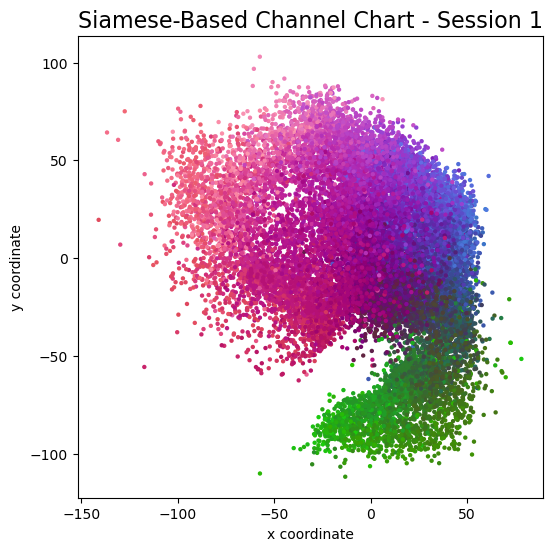

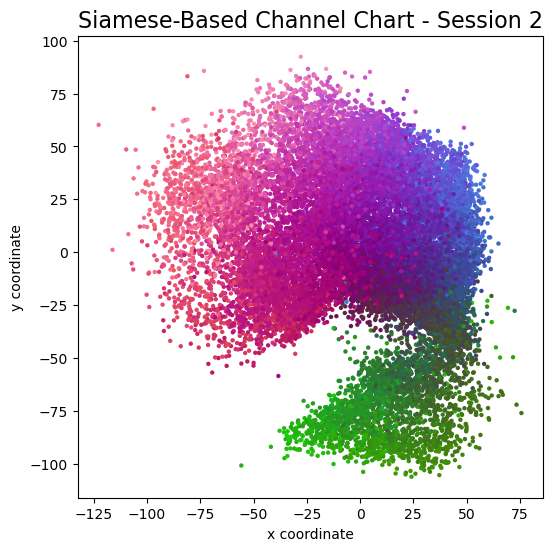

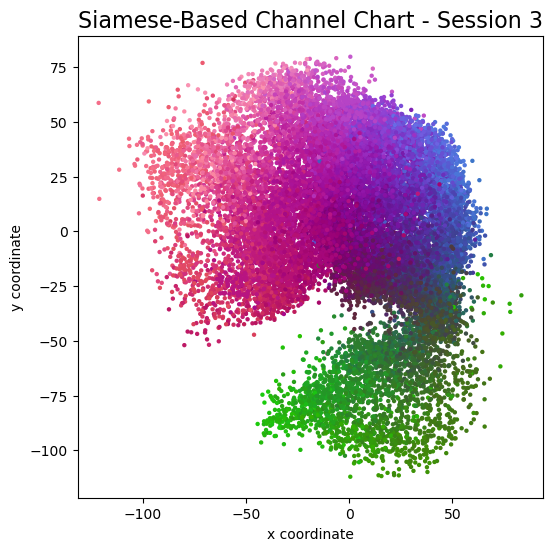

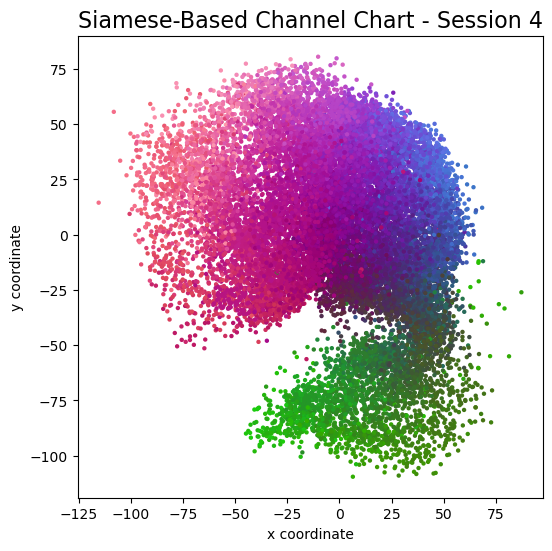

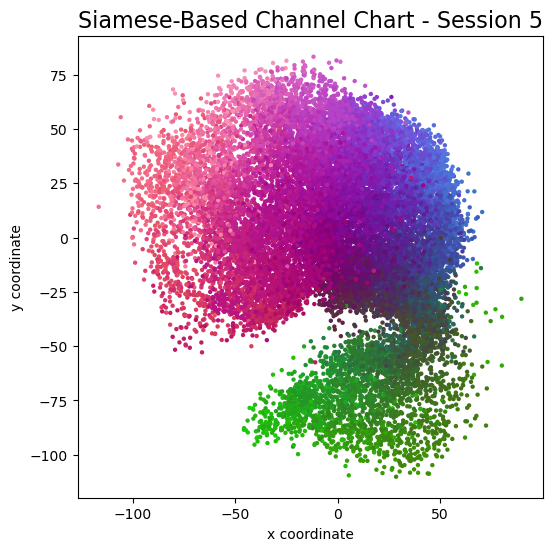

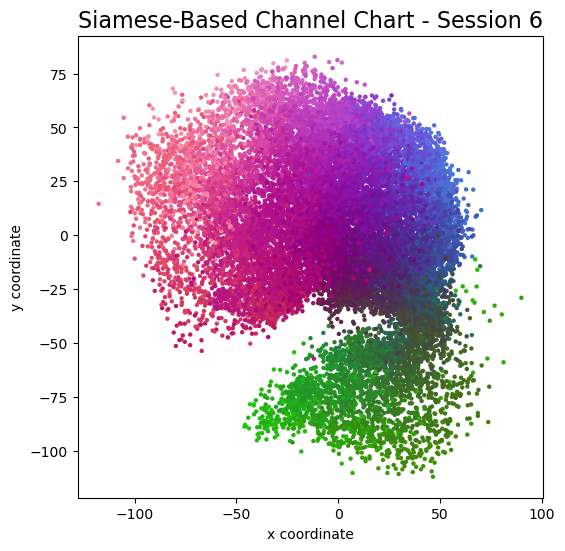

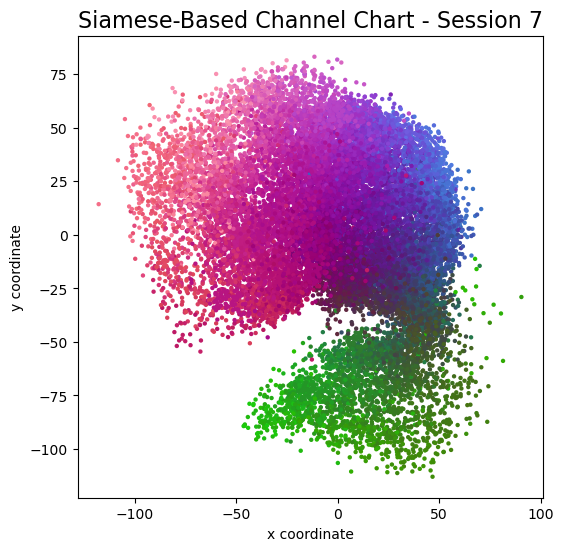

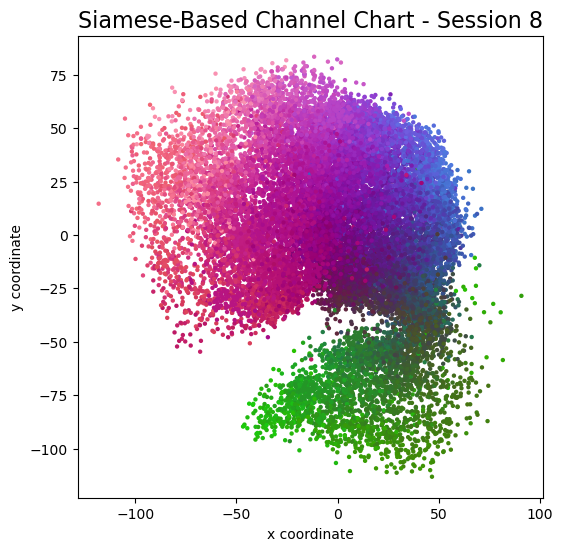

In [23]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = siamese_loss, optimizer = optimizer)

samples_per_session = 150000
learning_rates = [1e-2, 1e-2, 8e-3, 4e-3, 1e-3, 5e-4, 2e-4, 1e-4]
batch_size = [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

for l in range(len(learning_rates)):
    print("\nTraining Session ", l + 1, "\nBatch Size: ", batch_size[l], "\nLearning rate: ", learning_rates[l])

    # Fit model
    optimizer.learning_rate.assign(learning_rates[l])
    model.fit(random_pair_dataset.batch(batch_size[l]).prefetch(tf.data.AUTOTUNE), steps_per_epoch = samples_per_session // batch_size[l])

    # Plot Channel Chart
    print("Running inference to plot channel chart")
    channel_chart_positions = cc_embmodel.predict(csi_time_domain)
    plot_colorized(channel_chart_positions, groundtruth_positions, title = "Siamese-Based Channel Chart - Session " + str(l + 1))
    plt.savefig('channel_chart_session_' + str(l + 1) + '.png', dpi=300, bbox_inches='tight')

In [24]:
csi_time_domain_tensor = tf.constant(csi_time_domain)
dissimilarity_matrix_geodesic_tensor = tf.constant(dissimilarity_matrix_geodesic)

datapoint_count = tf.shape(csi_time_domain_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    return (csi_time_domain_tensor[randA % datapoint_count], csi_time_domain_tensor[randB % datapoint_count]), dissimilarity_matrix_geodesic_tensor[randA % datapoint_count, randB % datapoint_count]

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)

657/657 [==============================] - 20s 30ms/step


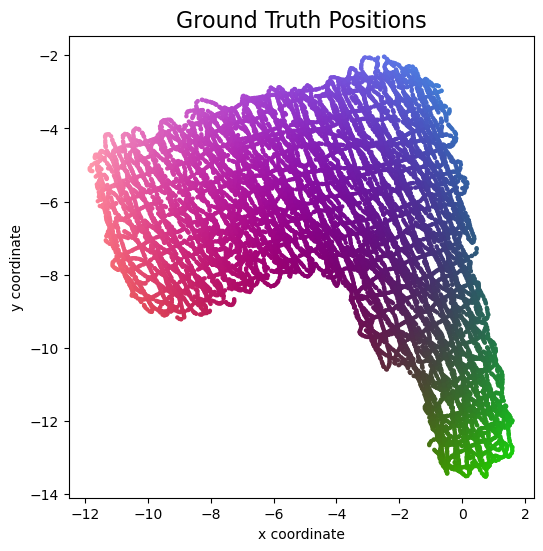

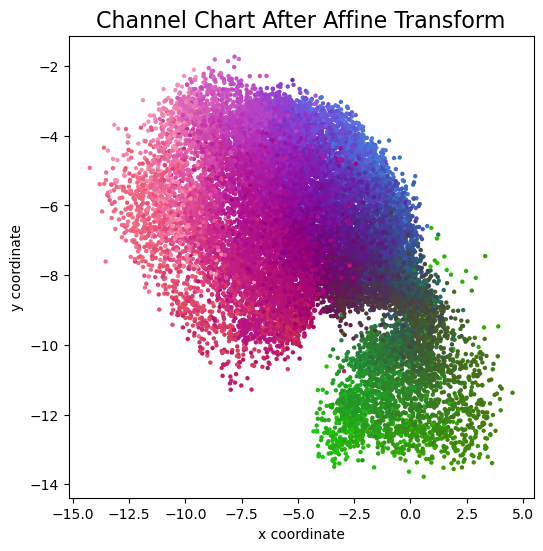

In [25]:
channel_chart_positions = cc_embmodel.predict(csi_time_domain)

def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

channel_chart_positions_transformed = affine_transform_channel_chart(groundtruth_positions, channel_chart_positions)
plot_colorized(groundtruth_positions, groundtruth_positions, title = "Ground Truth Positions")

plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "Channel Chart After Affine Transform")


NameError: name 'channel_chart_positions' is not defined

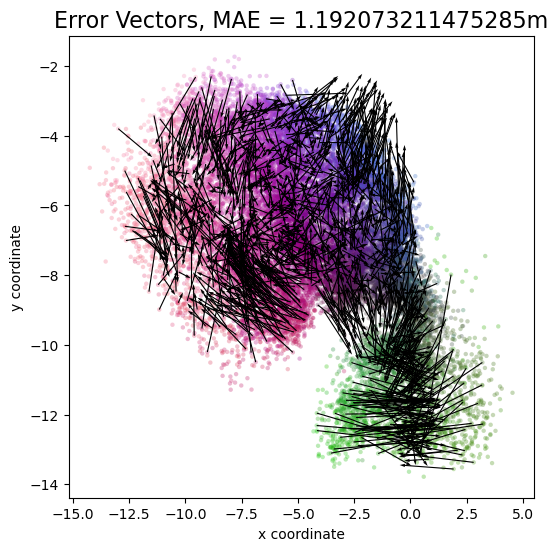

In [26]:
errorvectors = groundtruth_positions - channel_chart_positions_transformed
errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.mean(errors)

nth_errorvector = 15
plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "Error Vectors, MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(channel_chart_positions_transformed[::nth_errorvector, 0], channel_chart_positions_transformed[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)


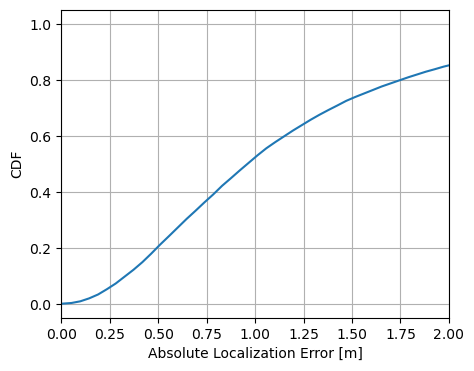

In [27]:
count, bins_count = np.histogram(errors, bins=200)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

bins_count[0] = 0
cdf = np.append([0], cdf)

plt.figure(figsize=(5, 4))
plt.plot(bins_count, cdf)
plt.xlim((0, 2))
plt.xlabel("Absolute Localization Error [m]")
plt.ylabel("CDF")
plt.grid()


In [28]:
# Continuity is identical to trustworthiness, except that original space and embedding space are swapped
def continuity(*args, **kwargs):
	args = list(args)
	args[0], args[1] = args[1], args[0]
	return trustworthiness(*args, **kwargs)

def kruskal_stress(X, X_embedded):
	dist_X = distance_matrix(X, X)
	dist_X_embedded = distance_matrix(X_embedded, X_embedded)
	beta = np.divide(np.sum(dist_X * dist_X_embedded), np.sum(dist_X_embedded * dist_X_embedded))

	return np.sqrt(np.divide(np.sum(np.square((dist_X - beta * dist_X_embedded))), np.sum(dist_X * dist_X)))

In [29]:
# Evaluate CT / TW / KS on a subset of the whole dataset
subset_indices = random.sample(range(len(groundtruth_positions)), len(groundtruth_positions) // 5)
groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_subset = channel_chart_positions[subset_indices]

ct = continuity(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw = trustworthiness(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_subset)

print("CT: {} \nTW: {} \nKS: {}".format(*np.around((ct, tw, ks), 5)))

CT: 0.96016 
TW: 0.95867 
KS: 0.23698
